# Explaining Keras image classifier predictions

If we have a model that takes in an image as input, and outputs a class score, we can use ELI5 to check what is it in the image that made the model decide a certain class score. We do that using a method called 'Grad-CAM'.

We will be using images from ImageNet (for more information see http://image-net.org/), and classifiers from `keras.applications`. This has been tested with Python 3.7.3, Keras 2.2.4, and Tensorflow 1.13.1.

## 1. Explaining the model's prediction

To start out, lets load our classifier and data.

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.


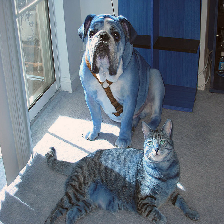

In [1]:
import keras
from keras.applications import resnet50
import eli5

# let's instantiate our model
resnet = resnet50.ResNet50(include_top=True, weights='imagenet', classes=1000)

# and load our sample image
image = 'samples/cat_dog.jpg'  # TODO: replace this image with something more interesting


# we need to load it as a numpy array
doc = eli5.keras.image_from_path(image, image_shape=resnet.input_shape[1:3]) # 224x224
# optional preprocessing specific to resnet
doc = resnet50.preprocess_input(doc) # note that this operation is in-place

# looking good?
from PIL import Image
from IPython.display import display
display(keras.preprocessing.image.array_to_img(doc[0]))

Let's classify our image and explain that classification

Taking top prediction: 243
Instructions for updating:
Use tf.cast instead.


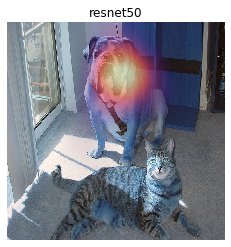

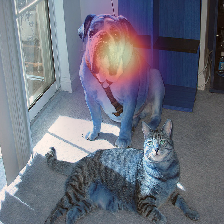

In [2]:
eli5.show_prediction(resnet, doc)

We can see a highlighted region. This is what influenced the model's prediction the most.

## 2. Choosing the target class

We can make the model classify other objects and check where the classifier looks to make its decisions.

This time we will use the `eli5.explain_prediction` and `eli5.format_as_image` functions (that are called together by `eli5.show_prediction`) to better understand what is going on.

In [3]:
tiger_cat_idx = 282 # ImageNet id for "tiger_cat" class
expl = eli5.explain_prediction(resnet, doc, targets=[tiger_cat_idx])

Let's have a look at the explanation

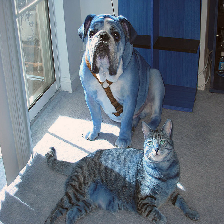

In [4]:
display(expl.image)
display(expl.heatmap)

After resizing the heatmap ...

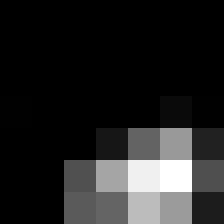

In [5]:
display(expl.heatmap.resize((expl.image.height, expl.image.width)))

Now it's clear what is being highlighted. We just need to overlay the heatmap over the original image. For that we can use the `eli5.format_as_image` function.

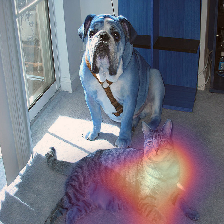

In [6]:
I = eli5.format_as_image(expl)
display(I)

`format_as_image` has a couple of parameters too:

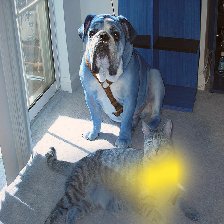

In [7]:
import matplotlib.cm

I = eli5.format_as_image(expl, alpha_limit=255., colormap=matplotlib.cm.cividis)
display(I)

## 3. Choosing a hidden layer

Under the hood Grad-CAM takes a hidden layer inside the network and differentiates it with respect to the output scores. We have the ability to choose which hidden layer we do our computations on.

Let's check what layers the network consists of:

In [8]:
resnet.summary() # check what layers are available

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

Let's pick a few convolutional layers that are 'far apart':

Taking top prediction: 243


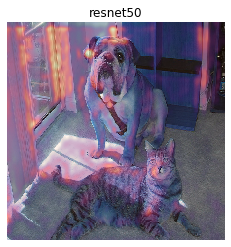

Taking top prediction: 243


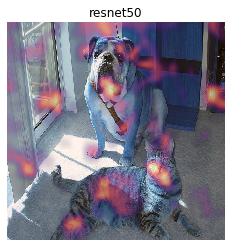

Taking top prediction: 243


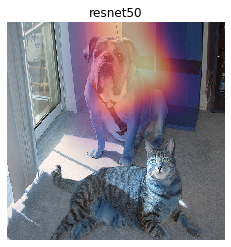

In [9]:
for l in ['res2a_branch2b', 'res3d_branch2c', 'res5c_branch2c']:
    eli5.show_prediction(resnet, doc, layer=l)

This should make intuitive sense for CNN's. Initial layers detect 'lower level' features. Finishing layers detect 'high level' features!

## 4. Comparing explanations of different models

According to the paper at https://arxiv.org/abs/1711.06104, if an explanation method such as Grad-CAM is good, then explaining different models should yield different results. Let's verify that by loading another model and explaining a classification of the same image:

Taking top prediction: 243


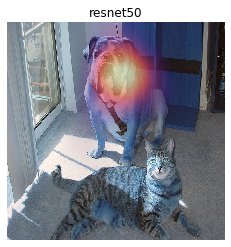

Taking top prediction: 243


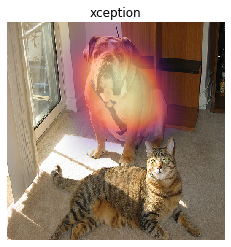

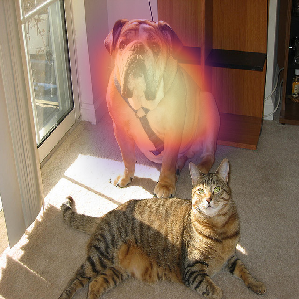

In [10]:
from keras.applications import xception

xcept = xception.Xception(include_top=True, weights='imagenet', classes=1000)

doc2 = eli5.keras.image_from_path(image, image_shape=xcept.input_shape[1:3])
doc2 = xception.preprocess_input(doc2)

eli5.show_prediction(resnet, doc)
eli5.show_prediction(xcept, doc2)

The explanations do look different!